In [451]:
import pandas as pd
import numpy as np
import seaborn as sns
import joblib
from matplotlib import pyplot as plt
from matplotlib import rcParams
from numpy.typing import NDArray
from functools import lru_cache
from typing import Any, Union
import ipywidgets as widgets
import warnings
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder


from sklearn.linear_model import LinearRegression


In [452]:
df = pd.read_csv("Задания/Datasets/Australian Vehicle Prices.csv", index_col=False)
print("DF Size:" ,df.shape)
df.head(5)

DF Size: (16734, 19)


,Brand,Year,Model,Car/Suv,Title,UsedOrNew,Transmission,Engine,DriveType,FuelType,FuelConsumption,Kilometres,ColourExtInt,Location,CylindersinEngine,BodyType,Doors,Seats,Price
0,Ssangyong,2022.0,Rexton,Sutherland Isuzu Ute,2022 Ssangyong Rexton Ultimate (awd),DEMO,Automatic,"4 cyl, 2.2 L",AWD,Diesel,8.7 L / 100 km,5595,White / Black,"Caringbah, NSW",4 cyl,SUV,4 Doors,7 Seats,51990
1,MG,2022.0,MG3,Hatchback,2022 MG MG3 Auto Excite (with Navigation),USED,Automatic,"4 cyl, 1.5 L",Front,Premium,6.7 L / 100 km,16,Black / Black,"Brookvale, NSW",4 cyl,Hatchback,5 Doors,5 Seats,19990
2,BMW,2022.0,430I,Coupe,2022 BMW 430I M Sport,USED,Automatic,"4 cyl, 2 L",Rear,Premium,6.6 L / 100 km,8472,Grey / White,"Sylvania, NSW",4 cyl,Coupe,2 Doors,4 Seats,108988
3,Mercedes-Benz,2011.0,E500,Coupe,2011 Mercedes-Benz E500 Elegance,USED,Automatic,"8 cyl, 5.5 L",Rear,Premium,11 L / 100 km,136517,White / Brown,"Mount Druitt, NSW",8 cyl,Coupe,2 Doors,4 Seats,32990
4,Renault,2022.0,Arkana,SUV,2022 Renault Arkana Intens,USED,Automatic,"4 cyl, 1.3 L",Front,Unleaded,6 L / 100 km,1035,Grey / Black,"Castle Hill, NSW",4 cyl,SUV,4 Doors,5 Seats,34990


In [453]:
#Brand: Name of the car manufacturer
#Year: Year of manufacture or release
#Model: Name or code of the car model
#Car/Suv: Type of the car (car or suv)
#Title: Title or description of the car
#UsedOrNew: Condition of the car (used or new)
#Transmission: Type of transmission (manual or automatic)
#Engine: Engine capacity or power (in litres or kilowatts)
#DriveType: Type of drive (front-wheel, rear-wheel, or all-wheel)
#FuelType: Type of fuel (petrol, diesel, hybrid, or electric)
#FuelConsumption: Fuel consumption rate (in litres per 100 km)
#Kilometres: Distance travelled by the car (in kilometres)
#ColourExtInt: Colour of the car (exterior and interior)
#Location: Location of the car (city and state)
#CylindersinEngine: Number of cylinders in the engine
#BodyType: Shape or style of the car body (sedan, hatchback, coupe, etc.)
#Doors: Number of doors in the car
#Seats: Number of seats in the car
#Price: Price of the car (in Australian dollars)

In [454]:
(df.shape)

(16734, 19)

In [455]:
#check for nulls
df.iloc[0]
df.nunique()
df['Price'].unique()
if 0 in df['Price'].unique():
    print("YES")
else:
    print("NO")

NO


In [456]:
#Encode to float64 
df = df[pd.to_numeric(df['Kilometres'], errors='coerce').notna()]
df["Kilometres"] = df["Kilometres"].astype("float")
df = df[pd.to_numeric(df['Kilometres'], errors='coerce').notna()]
df["Kilometres"] = df["Kilometres"].astype("float")
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16142 entries, 0 to 16733
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Brand              16142 non-null  object 
 1   Year               16142 non-null  float64
 2   Model              16142 non-null  object 
 3   Car/Suv            16139 non-null  object 
 4   Title              16142 non-null  object 
 5   UsedOrNew          16142 non-null  object 
 6   Transmission       16142 non-null  object 
 7   Engine             16142 non-null  object 
 8   DriveType          16142 non-null  object 
 9   FuelType           16142 non-null  object 
 10  FuelConsumption    16142 non-null  object 
 11  Kilometres         16142 non-null  float64
 12  ColourExtInt       16142 non-null  object 
 13  Location           16142 non-null  object 
 14  CylindersinEngine  16142 non-null  object 
 15  BodyType           15873 non-null  object 
 16  Doors              14574 no

In [457]:
#Feature enineering
def featureEngine(x):
    x.replace('None', np.nan, inplace=True)
    x.replace('-', np.nan, inplace=True)
    x.replace('nan', np.nan, inplace=True)
    
    x.dropna(subset=['Year'], inplace=True)
    x.dropna(subset=['Price'], inplace=True)
    x.drop(['Title'], axis = 1, inplace = True) 
    
    x.drop(['Car/Suv'], axis = 1, inplace = True)
    
    x['Year'] = x['Year'].astype('float')
    
    x[['EngineCLY','EngineL']] = x['Engine'].astype(str).str.split(", ",expand = True)
    x['Engine'] = x['EngineL']
    x['Engine'] = x['Engine'].astype(str).str.replace(' L', "")
    x.drop(['EngineCLY'], axis = 1, inplace = True) 
    x.drop(['EngineL'], axis = 1, inplace = True)
    x.rename(columns={'Engine': 'EngineL'}, inplace=True)
    x['EngineL'].replace('None', 0, inplace=True)
    x['EngineL'] = x['EngineL'].astype('float')
    
    x[['FuelC','KM']] = x['FuelConsumption'].astype(str).str.split(" / ",expand = True)
    x['FuelConsumption'] = x['FuelC']
    x['FuelConsumption'] = x['FuelConsumption'].astype(str).str.replace(' L', "")
    x.drop(['KM'], axis = 1, inplace = True)
    x.drop(['FuelC'], axis = 1, inplace = True)
    x['FuelConsumption'].replace('nan', 0, inplace=True)
    x['FuelConsumption'] = x['FuelConsumption'].astype('float')
    
    x['Kilometres'] = x['Kilometres']
    
    ll=[]
    for i in x['ColourExtInt']:
        xv=''
        for j in str(i):
            if j=='/':
                pass
            else:
                xv=xv+j
        ll.append(xv)
        xv=''
    x['ColourExtInt']=ll
    x.rename(columns={'ColourExtInt': 'Color'}, inplace=True)
    x['Color'] = x['Color'].astype(str).str.replace(' -', "")
    
    x[['City','State']] = x['Location'].astype(str).str.split(", ",expand = True)
    x['State'].replace({None: np.nan}, inplace=True)
    x.drop(['Location'], axis = 1, inplace = True)
    
    x['CylindersinEngine'] = x['CylindersinEngine'].fillna(0).astype(str)
    x['CylindersinEngine'] = x['CylindersinEngine'].astype(str).str.extract('(\d+)').astype('float32')
    x['CylindersinEngine'] = x['CylindersinEngine'].fillna(0).astype('float')
    
    x['Doors'] = x['Doors'].fillna(0).astype(str)
    x['Doors'] = x['Doors'].astype(str).str.extract('(\d+)').astype('float')
    
    x['Seats'] = x['Seats'].fillna(0).astype(str)
    x['Seats'] = x['Seats'].astype(str).str.extract('(\d+)').astype(float)
    
    x['Price'] = x['Price']
    
    x.replace('None', np.nan, inplace=True)
    x.replace('-', np.nan, inplace=True)
    x.replace('nan', np.nan, inplace=True)


In [458]:
#change the order of col
data = df.copy()
featureEngine(data)
new_order = ['Brand',
             'Model',
             'Year',
             'BodyType',
             'UsedOrNew',
             'Transmission',
             'EngineL',
             'DriveType',
             'FuelType',
             'FuelConsumption',
             'Kilometres',
             'Color',
             'CylindersinEngine',
             'Doors', 
             'Seats',
             'State',
             'City',
             'Price']  
data = data.reindex(columns=new_order)
data.head(5)

/var/folders/19/c1rn4t0n4qn2h0cjhj9f9_3r0000gn/T/ipykernel_15044/1738776898.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  x['EngineL'].replace('None', 0, inplace=True)
/var/folders/19/c1rn4t0n4qn2h0cjhj9f9_3r0000gn/T/ipykernel_15044/1738776898.py:29: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values alway

,Brand,Model,Year,BodyType,UsedOrNew,Transmission,EngineL,DriveType,FuelType,FuelConsumption,Kilometres,Color,CylindersinEngine,Doors,Seats,State,City,Price
0,Ssangyong,Rexton,2022.0,SUV,DEMO,Automatic,2.2,AWD,Diesel,8.7,5595.0,White Black,4.0,4.0,7.0,NSW,Caringbah,51990
1,MG,MG3,2022.0,Hatchback,USED,Automatic,1.5,Front,Premium,6.7,16.0,Black Black,4.0,5.0,5.0,NSW,Brookvale,19990
2,BMW,430I,2022.0,Coupe,USED,Automatic,2.0,Rear,Premium,6.6,8472.0,Grey White,4.0,2.0,4.0,NSW,Sylvania,108988
3,Mercedes-Benz,E500,2011.0,Coupe,USED,Automatic,5.5,Rear,Premium,11.0,136517.0,White Brown,8.0,2.0,4.0,NSW,Mount Druitt,32990
4,Renault,Arkana,2022.0,SUV,USED,Automatic,1.3,Front,Unleaded,6.0,1035.0,Grey Black,4.0,4.0,5.0,NSW,Castle Hill,34990


In [459]:
#convert to float all possible values and impute all null pos
def safe_convert_to_float(value):
    try:
        return float(value)
    except ValueError:
        return float('nan')

# List of numeric features
features_num = ['Year', 'EngineL', 'FuelConsumption', 'Kilometres', 'CylindersinEngine', 'Doors', 'Seats', 'Price']
features_col = ['Brand', 'Model', 'BodyType', 'UsedOrNew', 'Transmission', 'DriveType', 'FuelType', 'Color', 'State', 'City']

# Apply the safe conversion to the relevant columns
for columna in features_num:
    data[columna] = data[columna].apply(safe_convert_to_float)
    data.replace('nan', np.nan, inplace=True)
data = data.drop(columns=features_col)
data

,Year,EngineL,FuelConsumption,Kilometres,CylindersinEngine,Doors,Seats,Price
0,2022.0,2.2,8.7,5595.0,4.0,4.0,7.0,51990.0
1,2022.0,1.5,6.7,16.0,4.0,5.0,5.0,19990.0
2,2022.0,2.0,6.6,8472.0,4.0,2.0,4.0,108988.0
3,2011.0,5.5,11.0,136517.0,8.0,2.0,4.0,32990.0
4,2022.0,1.3,6.0,1035.0,4.0,4.0,5.0,34990.0
...,...,...,...,...,...,...,...,...
16729,2014.0,0.0,0.0,66000.0,0.0,7.0,0.0,29500.0
16730,2012.0,0.0,0.0,117432.0,0.0,0.0,0.0,39888.0
16731,2022.0,1.6,6.2,5165.0,4.0,4.0,5.0,35280.0
16732,2016.0,2.0,7.2,85525.0,4.0,4.0,5.0,41888.0


In [460]:
#data['CylindersinEngine'].nunique()
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16140 entries, 0 to 16733
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Year               16140 non-null  float64
 1   EngineL            16140 non-null  float64
 2   FuelConsumption    16140 non-null  float64
 3   Kilometres         16140 non-null  float64
 4   CylindersinEngine  16140 non-null  float64
 5   Doors              16140 non-null  float64
 6   Seats              16140 non-null  float64
 7   Price              16106 non-null  float64
dtypes: float64(8)
memory usage: 1.1 MB


In [461]:
#view all types of each cathegory
for col in df.select_dtypes('object').columns:
  print(col,' ',df[col].nunique())

Brand   70
Model   741
Car/Suv   608
Title   8401
UsedOrNew   3
Transmission   3
Engine   92
DriveType   5
FuelType   9
FuelConsumption   153
ColourExtInt   802
Location   617
CylindersinEngine   10
BodyType   10
Doors   13
Seats   12
Price   3405


In [462]:
data.nunique()
data.isnull().sum()
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16140 entries, 0 to 16733
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Year               16140 non-null  float64
 1   EngineL            16140 non-null  float64
 2   FuelConsumption    16140 non-null  float64
 3   Kilometres         16140 non-null  float64
 4   CylindersinEngine  16140 non-null  float64
 5   Doors              16140 non-null  float64
 6   Seats              16140 non-null  float64
 7   Price              16106 non-null  float64
dtypes: float64(8)
memory usage: 1.1 MB


In [463]:
for col in data.select_dtypes('object').columns:
  print(col,': ',data[col].nunique())

In [464]:
data.isnull().sum()

Year                  0
EngineL               0
FuelConsumption       0
Kilometres            0
CylindersinEngine     0
Doors                 0
Seats                 0
Price                34
dtype: int64

<Axes: xlabel='Price', ylabel='Count'>

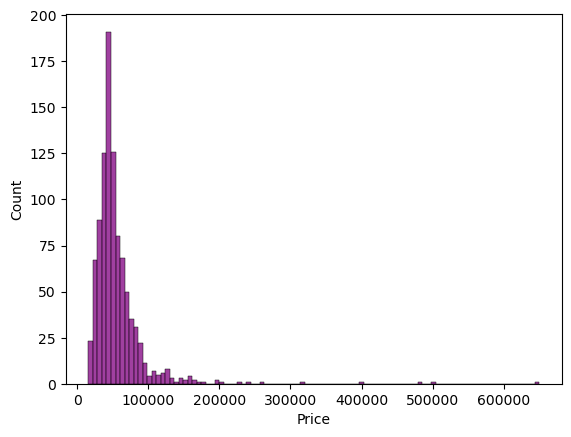

In [465]:
#hisplot for analyze
pattern = data[data['Kilometres'] <= 400]
sns.histplot((pattern['Price']), bins = 100, color = "purple")

In [466]:
#log price and kilometres
data = data.copy()

data['Kilometres'] = np.log(data['Kilometres'])
data['Price'] = np.log(data['Price'])
data = data[data['Year'] > 1980]

data = data.fillna(data.mean())
x=data.drop(['Price'],axis=1)
y=data['Price']

In [467]:
#sns.pairplot(data, plot_kws={'color': 'orange', 's': 200}, aspect = 2)  
## aspect — соотношение ширины к высоте
## s — размер точки
#plt.show()

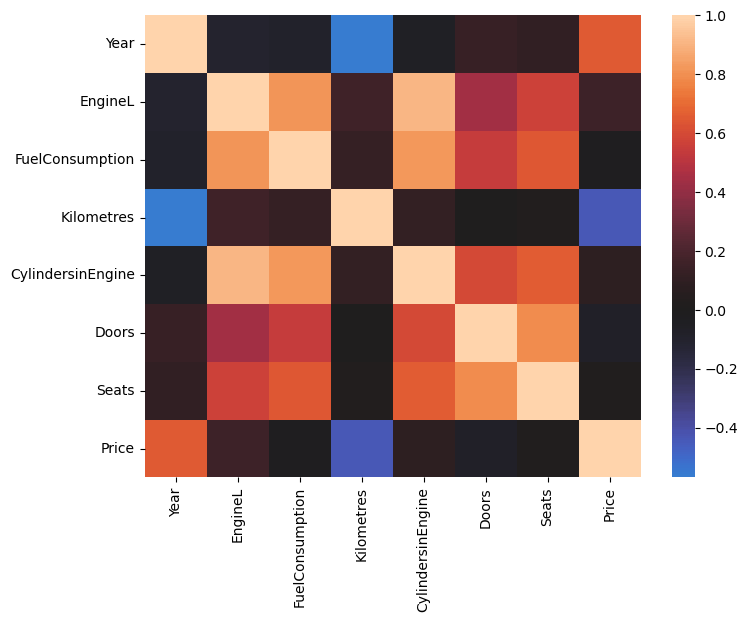

,Year,EngineL,FuelConsumption,Kilometres,CylindersinEngine,Doors,Seats,Price
Year,1.000000,-0.108593,-0.087201,-0.568652,-0.058906,0.127778,0.108509,0.654199
EngineL,-0.108593,1.000000,0.811352,0.163397,0.912167,0.440506,0.564040,0.149111
FuelConsumption,-0.087201,0.811352,1.000000,0.118328,0.826073,0.543009,0.638567,-0.021065
Kilometres,-0.568652,0.163397,0.118328,1.000000,0.115294,0.007180,0.026520,-0.434130
CylindersinEngine,-0.058906,0.912167,0.826073,0.115294,1.000000,0.593804,0.659189,0.092424
Doors,0.127778,0.440506,0.543009,0.007180,0.593804,1.000000,0.785854,-0.068006
Seats,0.108509,0.564040,0.638567,0.026520,0.659189,0.785854,1.000000,0.018037
Price,0.654199,0.149111,-0.021065,-0.434130,0.092424,-0.068006,0.018037,1.000000


In [468]:
#1
corr = data.corr()
plt.figure(1, figsize=(8, 6))  # Increase the height of the heatmap
sns.heatmap(corr,center=0)  # Reduce the font size of annotations
plt.show()
data.corr()

In [469]:
data.shape

(16134, 8)

In [470]:
feature_numeric = [cname for cname in data.columns if data[cname].dtype == "float"]
print(feature_numeric)

['Year', 'EngineL', 'FuelConsumption', 'Kilometres', 'CylindersinEngine', 'Doors', 'Seats', 'Price']


In [471]:
transform=ColumnTransformer(transformers=[
],remainder='passthrough')

In [472]:
#pick the used models
models = [
    ('lr',LinearRegression())
]
print(x.shape)
y.shape

(16134, 7)


(16134,)

Mean Squared Error: 0.171454193124111
R² Score: 0.5958967855806305


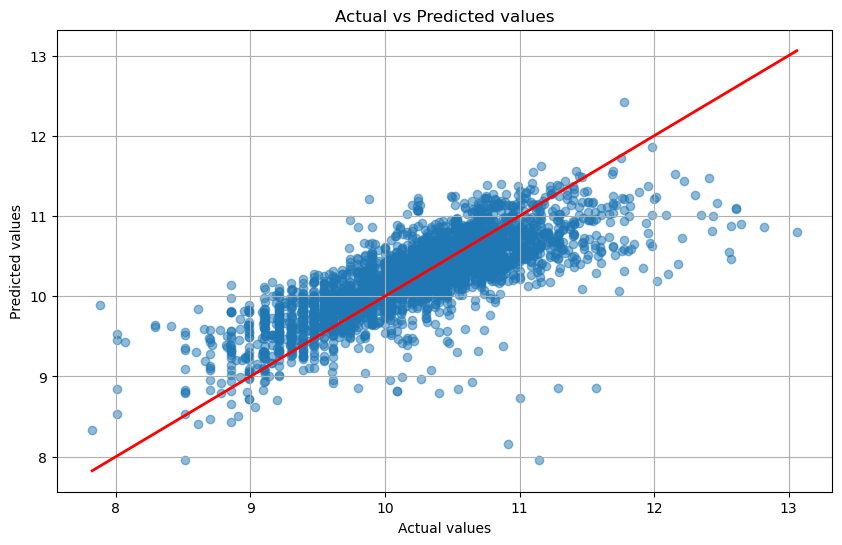

In [473]:
#2,3
# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Creating the linear regression model
model = LinearRegression()

# Fitting the model
model.fit(X_train, y_train)

# Making predictions
y_pred = model.predict(X_test)

# Evaluating the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R² Score: {r2}')

# Visualizing the predictions vs actual values (optional)
# For visualization, you'll need to pick one feature (e.g., the first feature)
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2)  # Diagonal line
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.title('Actual vs Predicted values')
plt.grid()
plt.show()

# Уравнение линейной регрессии

Для простой линейной регрессии уравнение имеет вид:

$$
y = b_0 + b_1 \cdot x
$$

Где:
- \( y \) — предсказанное значение зависимой переменной,
- \( x \) — значение независимой переменной,
- \( b_0 \) — свободный член (intercept),
- \( b_1 \) — коэффициент наклона (slope).

Для множественной линейной регрессии уравнение выглядит следующим образом:

$$
y = b_0 + b_1 \cdot x_1 + b_2 \cdot x_2 + \ldots + b_n \cdot x_n
$$

Где:
- \( x_1, x_2, \ldots, x_n \) — независимые переменные,
- \( b_1, b_2, \ldots, b_n \) — соответствующие коэффициенты наклона для каждой переменной.

In [474]:
#5,6 - t and F-statistic
# Добавляем константу к X для свободного члена
X_with_const = sm.add_constant(x)

# Разделяем данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X_with_const, y, test_size=0.2, random_state=42)

# Создаем модель линейной регрессии
model = sm.OLS(y_train, X_train)  # OLS - Ordinary Least Squares
results = model.fit()

# Получаем результаты
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.591
Model:                            OLS   Adj. R-squared:                  0.590
Method:                 Least Squares   F-statistic:                     2658.
Date:                Fri, 27 Sep 2024   Prob (F-statistic):               0.00
Time:                        09:27:19   Log-Likelihood:                -7075.6
No. Observations:               12907   AIC:                         1.417e+04
Df Residuals:                   12899   BIC:                         1.423e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              -157.5046      1.83

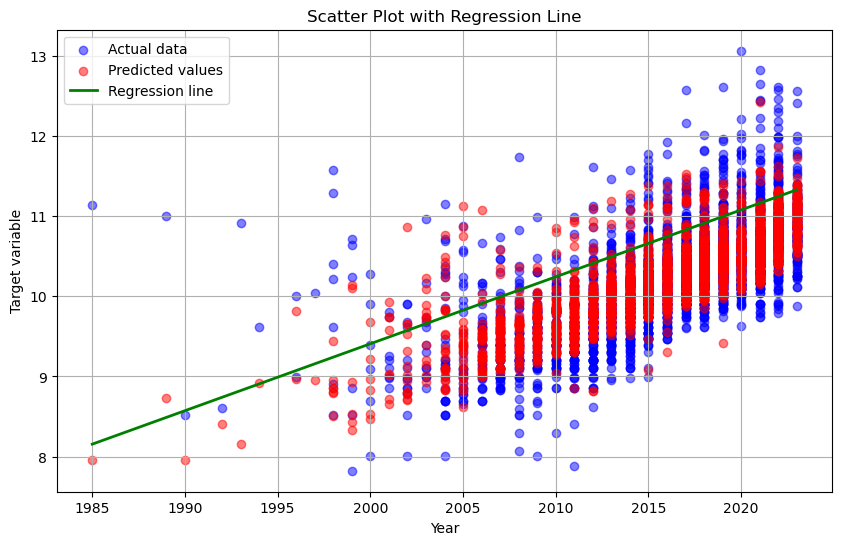

In [475]:
#7
# Добавляем константу к X для свободного члена
X_with_const = sm.add_constant(x)

# Разделяем данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X_with_const, y, test_size=0.2, random_state=42)

# Создаем модель OLS (метод наименьших квадратов)
model = sm.OLS(y_train, X_train)
results = model.fit()

# Предсказание значений
y_pred = results.predict(X_test)

# Выбираем одну из независимых переменных для визуализации
# В данном случае мы возьмем первую переменную
feature_to_plot = 'Year'  # замените на нужное имя столбца
# Построение графика рассеяния
plt.figure(figsize=(10, 6))
plt.scatter(X_test[feature_to_plot], y_test, color='blue', label='Actual data', alpha=0.5)
plt.scatter(X_test[feature_to_plot], y_pred, color='red', label='Predicted values', alpha=0.5)

# Уравнение регрессии
# Получаем коэффициенты
intercept = results.params['const']
slope = results.params[feature_to_plot]

# Создаем линию регрессии
x_values = np.linspace(X_test[feature_to_plot].min(), X_test[feature_to_plot].max(), 100)
y_values = intercept + slope * x_values

# Рисуем линию регрессии
plt.plot(x_values, y_values, color='green', linewidth=2, label='Regression line')

# Настройки графика
plt.title('Scatter Plot with Regression Line')
plt.xlabel(feature_to_plot)
plt.ylabel('Target variable')
plt.legend()
plt.grid()
plt.show()

Dependence of Year Coefficient:
Slope: 0.0835, 95% CI: [0.0817, 0.0852]


/var/folders/19/c1rn4t0n4qn2h0cjhj9f9_3r0000gn/T/ipykernel_15044/2467674301.py:46: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'Slope: {slope:.4f}, 95% CI: [{slope_conf[0]:.4f}, {slope_conf[1]:.4f}]')


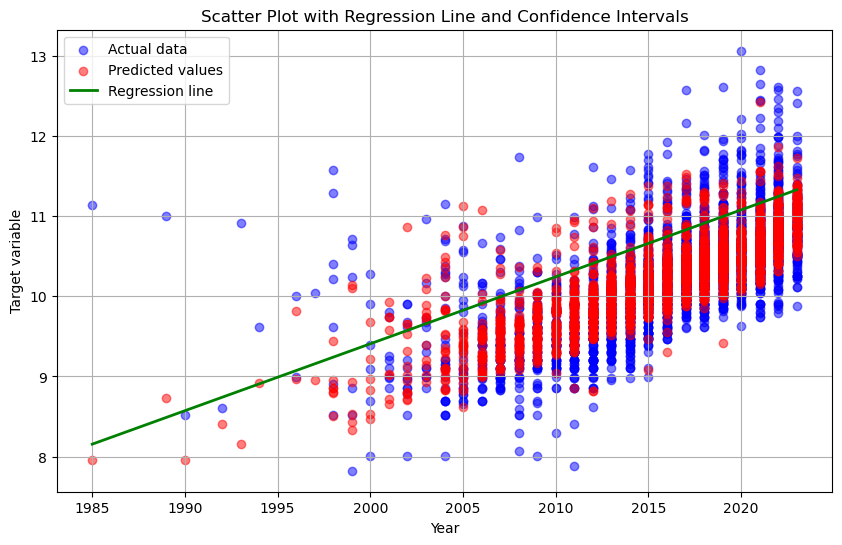

In [476]:
#8
# Добавляем константу к X для свободного члена
X_with_const = sm.add_constant(x)

# Разделяем данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X_with_const, y, test_size=0.2, random_state=42)

# Создаем модель OLS (метод наименьших квадратов)
model = sm.OLS(y_train, X_train)
results = model.fit()

# Предсказание значений
y_pred = results.predict(X_test)

# Выбираем одну из независимых переменных для визуализации
feature_to_plot = 'Year'  # замените на нужное имя столбца

# Построение графика рассеяния
plt.figure(figsize=(10, 6))
plt.scatter(X_test[feature_to_plot], y_test, color='blue', label='Actual data', alpha=0.5)
plt.scatter(X_test[feature_to_plot], y_pred, color='red', label='Predicted values', alpha=0.5)

# Уравнение регрессии
intercept = results.params['const']
slope = results.params[feature_to_plot]

# Создаем линию регрессии
x_values = np.linspace(X_test[feature_to_plot].min(), X_test[feature_to_plot].max(), 100)
y_values = intercept + slope * x_values

# Рисуем линию регрессии
plt.plot(x_values, y_values, color='green', linewidth=2, label='Regression line')

# Построение доверительных интервалов для коэффициента
conf = results.conf_int(alpha=0.05)  # 95% доверительный интервал
conf.columns = ['2.5%', '97.5%']  # Переименование колонок

# Получение доверительных интервалов для текущего коэффициента
slope_conf = conf.loc[feature_to_plot]

# Вывод доверительных интервалов в консоль
print(f'Dependence of {feature_to_plot} Coefficient:')
print(f'Slope: {slope:.4f}, 95% CI: [{slope_conf[0]:.4f}, {slope_conf[1]:.4f}]')

# Настройки графика
plt.title('Scatter Plot with Regression Line and Confidence Intervals')
plt.xlabel(feature_to_plot)
plt.ylabel('Target variable')
plt.legend()
plt.grid()
plt.show()

Индексы влиятельных наблюдений: [   26   101   111   163   184   220   264   266   275   284   287   300
   305   325   330   339   348   360   371   378   388   397   403   411
   419   441   454   495   516   531   533   535   554   575   586   595
   603   610   616   622   644   676   700   715   760   764   770   773
   783   784   827   833   834   839   847   866   872   896   897   900
   905   929   937   939   947   949   950   952   953   971   982   988
  1028  1030  1039  1061  1124  1129  1144  1146  1168  1189  1199  1263
  1304  1313  1315  1322  1415  1428  1443  1455  1464  1476  1507  1526
  1528  1529  1551  1558  1579  1602  1630  1632  1647  1674  1685  1692
  1722  1725  1726  1739  1751  1789  1791  1828  1850  1851  1858  1884
  1888  1902  1926  1937  1968  1973  1975  1990  1992  2001  2015  2016
  2026  2043  2045  2060  2067  2070  2098  2102  2159  2160  2169  2179
  2182  2185  2223  2231  2232  2245  2251  2253  2268  2277  2294  2323
  2329  2331  2335 

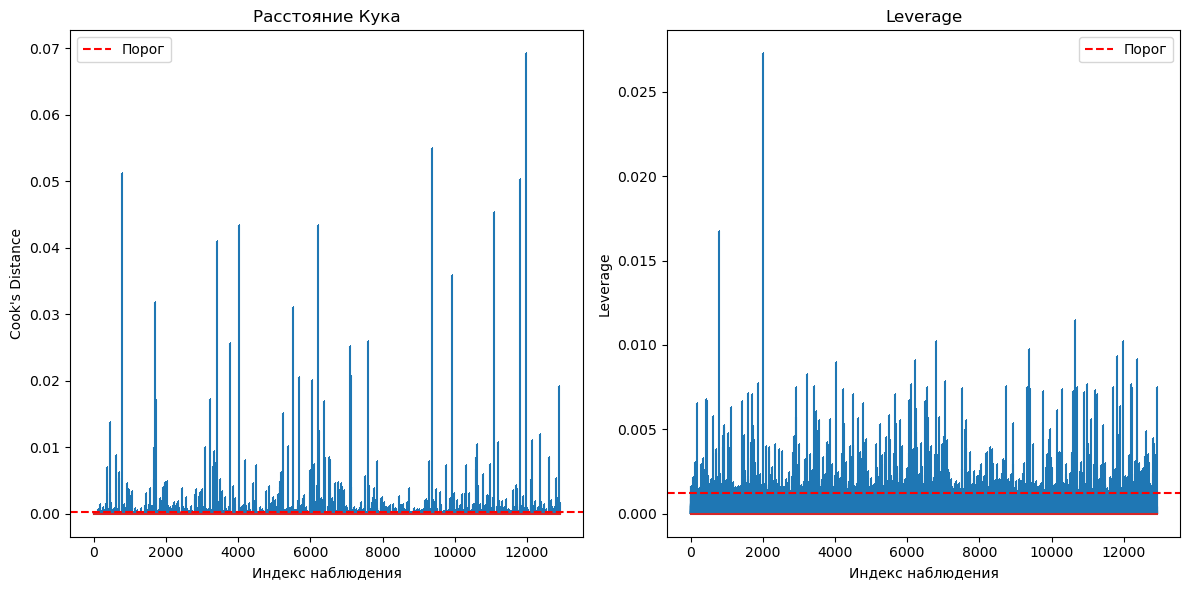

In [478]:
#9
# Добавляем константу к X для свободного члена
X_with_const = sm.add_constant(x)

# Разделяем данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X_with_const, y, test_size=0.2, random_state=42)

# Создаем модель OLS (метод наименьших квадратов)
model = sm.OLS(y_train, X_train)
results = model.fit()

# Рассчитываем расстояние Кука и давление
influence = results.get_influence()
cooks_d = influence.cooks_distance[0]
leverage = influence.hat_matrix_diag

# Порог для выявления влиятельных наблюдений
threshold_cooks = 4 / len(X_train)

# Индексы влиятельных наблюдений
influential_points = np.where(cooks_d > threshold_cooks)[0]

# Выводим влиятельные наблюдения
print("Индексы влиятельных наблюдений:", influential_points)

# Визуализация расстояния Кука
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.stem(np.arange(len(cooks_d)), cooks_d, markerfmt=",")
plt.axhline(y=threshold_cooks, color='r', linestyle='--', label='Порог')
plt.title('Расстояние Кука')
plt.xlabel('Индекс наблюдения')
plt.ylabel('Cook\'s Distance')
plt.legend()

# Визуализация давления
plt.subplot(1, 2, 2)
plt.stem(np.arange(len(leverage)), leverage, markerfmt=",")
plt.axhline(y=2 * (X_train.shape[1] / len(X_train)), color='r', linestyle='--', label='Порог')
plt.title('Leverage')
plt.xlabel('Индекс наблюдения')
plt.ylabel('Leverage')
plt.legend()

plt.tight_layout()
plt.show()

In [479]:
#10
# Функция для пошагового выбора переменных
def stepwise_selection(X, y, initial_features, threshold_in=0.05, threshold_out=0.05):
    included = list(initial_features)
    while True:
        changed = False

        # Подбор переменных (вход)
        X_with_const = sm.add_constant(X[included])
        model = sm.OLS(y, X_with_const).fit()
        pvalues = model.pvalues.iloc[1:]  # игнорируем p-value для константы

        # Проверка переменных на выход
        for feature in included:
            if pvalues[feature] > threshold_out:
                included.remove(feature)
                changed = True
                print(f"Removed {feature} with p-value {pvalues[feature]:.4f}")
                break

        # Подбор переменных (выход)
        X_with_const = sm.add_constant(X[included])
        model = sm.OLS(y, X_with_const).fit()
        pvalues = model.pvalues.iloc[1:]  # игнорируем p-value для константы

        # Проверка новых переменных на вход
        for feature in X.columns:
            if feature not in included:
                X_temp = X_with_const.copy()
                X_temp[feature] = X[feature]
                model_temp = sm.OLS(y, X_temp).fit()
                if model_temp.pvalues[feature] < threshold_in:
                    included.append(feature)
                    changed = True
                    print(f"Added {feature} with p-value {model_temp.pvalues[feature]:.4f}")
                    break

        if not changed:
            break
    return included

# Разделяем данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Инициализация начальных переменных (все переменные)
initial_features = X_train.columns.tolist()

# Выполняем пошаговый выбор переменных
selected_features = stepwise_selection(X_train, y_train, initial_features)

# Обучаем финальную модель с выбранными переменными
X_final = sm.add_constant(X_train[selected_features])
final_model = sm.OLS(y_train, X_final).fit()

# Предсказание значений на тестовой выборке
X_test_final = sm.add_constant(X_test[selected_features])
y_pred_final = final_model.predict(X_test_final)

# Выводим результаты финальной модели
print(final_model.summary())

Removed CylindersinEngine with p-value 0.5921
Removed Seats with p-value 0.5342
                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.591
Model:                            OLS   Adj. R-squared:                  0.590
Method:                 Least Squares   F-statistic:                     3722.
Date:                Fri, 27 Sep 2024   Prob (F-statistic):               0.00
Time:                        09:35:00   Log-Likelihood:                -7076.0
No. Observations:               12907   AIC:                         1.416e+04
Df Residuals:                   12901   BIC:                         1.421e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------

Removed CylindersinEngine with p-value 0.5921
Removed Seats with p-value 0.5342
Индексы влиятельных наблюдений: [  101   111   163   184   220   264   266   275   284   305   330   339
   348   350   360   371   378   388   397   403   407   411   441   452
   454   457   495   519   531   533   535   564   575   586   595   603
   610   616   622   676   687   700   715   760   764   773   783   784
   827   833   834   839   847   849   866   871   872   896   900   905
   929   937   939   947   950   952   953   971   982  1028  1030  1039
  1061  1124  1129  1144  1146  1162  1168  1189  1199  1263  1304  1313
  1315  1415  1428  1442  1443  1455  1464  1476  1507  1526  1528  1529
  1551  1558  1577  1579  1602  1630  1632  1647  1674  1685  1692  1722
  1725  1726  1739  1751  1789  1791  1828  1834  1850  1851  1858  1884
  1888  1926  1937  1950  1968  1975  1990  1992  2001  2015  2016  2026
  2043  2045  2060  2067  2070  2098  2102  2159  2160  2169  2179  2182
  2185  2201

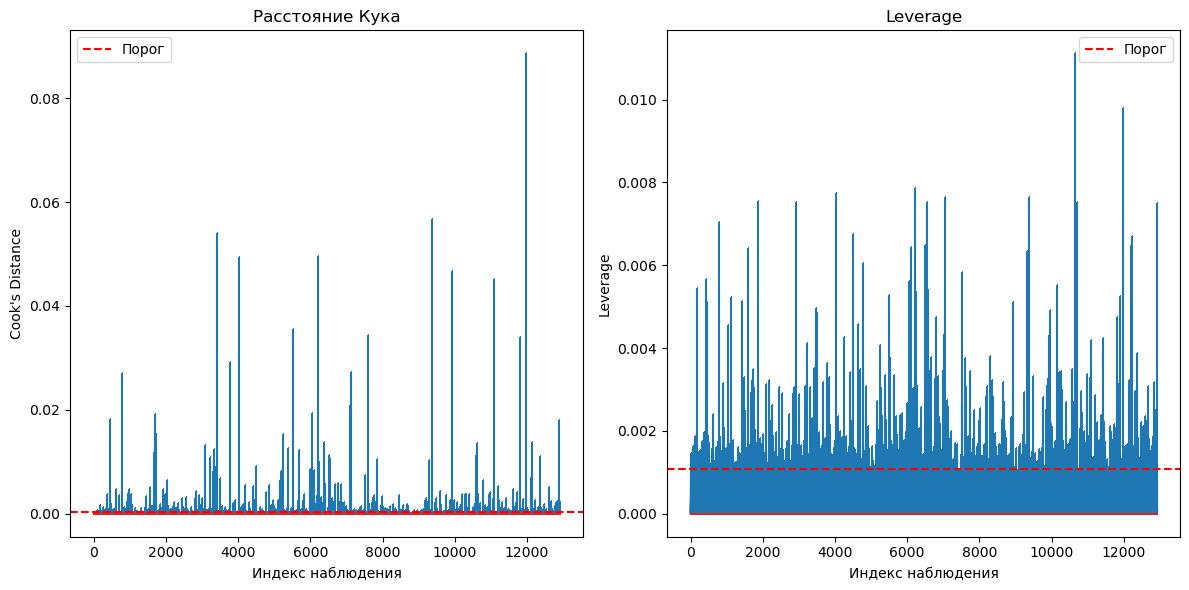

In [488]:
#11
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Инициализация начальных переменных (все переменные)
initial_features = X_train.columns.tolist()

# Выполняем пошаговый выбор переменных
selected_features = stepwise_selection(X_train, y_train, initial_features)

# Обучаем финальную модель с выбранными переменными
X_final = sm.add_constant(X_train[selected_features])
final_model = sm.OLS(y_train, X_final).fit()

# Предсказание значений на тестовой выборке
X_test_final = sm.add_constant(X_test[selected_features])
y_pred_final = final_model.predict(X_test_final)

# Рассчитываем расстояние Кука и давление
influence = results.get_influence()
cooks_d = influence.cooks_distance[0]
leverage = influence.hat_matrix_diag

# Порог для выявления влиятельных наблюдений
threshold_cooks = 4 / len(X_train)

# Индексы влиятельных наблюдений
influential_points = np.where(cooks_d > threshold_cooks)[0]

# Выводим влиятельные наблюдения
print("Индексы влиятельных наблюдений:", influential_points)

# Визуализация расстояния Кука
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.stem(np.arange(len(cooks_d)), cooks_d, markerfmt=",")
plt.axhline(y=threshold_cooks, color='r', linestyle='--', label='Порог')
plt.title('Расстояние Кука')
plt.xlabel('Индекс наблюдения')
plt.ylabel('Cook\'s Distance')
plt.legend()

# Визуализация давления
plt.subplot(1, 2, 2)
plt.stem(np.arange(len(leverage)), leverage, markerfmt=",")
plt.axhline(y=2 * (X_train.shape[1] / len(X_train)), color='r', linestyle='--', label='Порог')
plt.title('Leverage')
plt.xlabel('Индекс наблюдения')
plt.ylabel('Leverage')
plt.legend()

plt.tight_layout()
plt.show()

Removed CylindersinEngine with p-value 0.5921
Removed Seats with p-value 0.5342


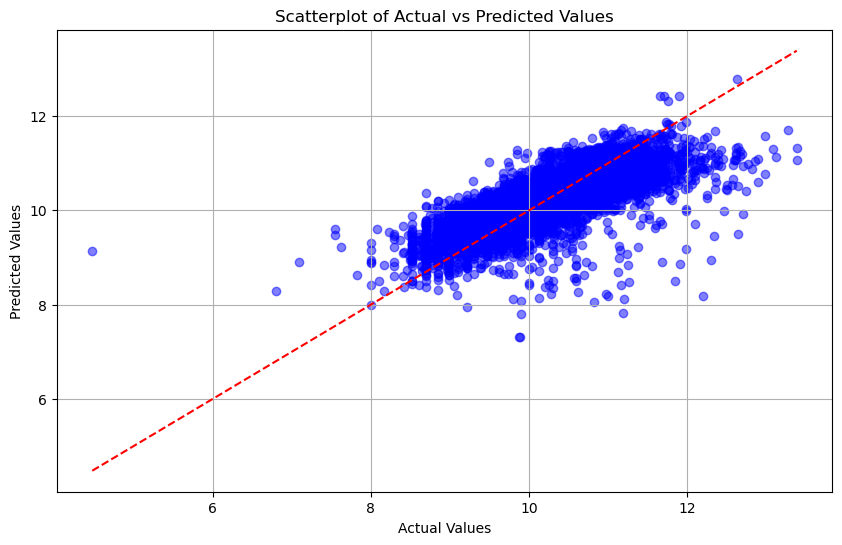

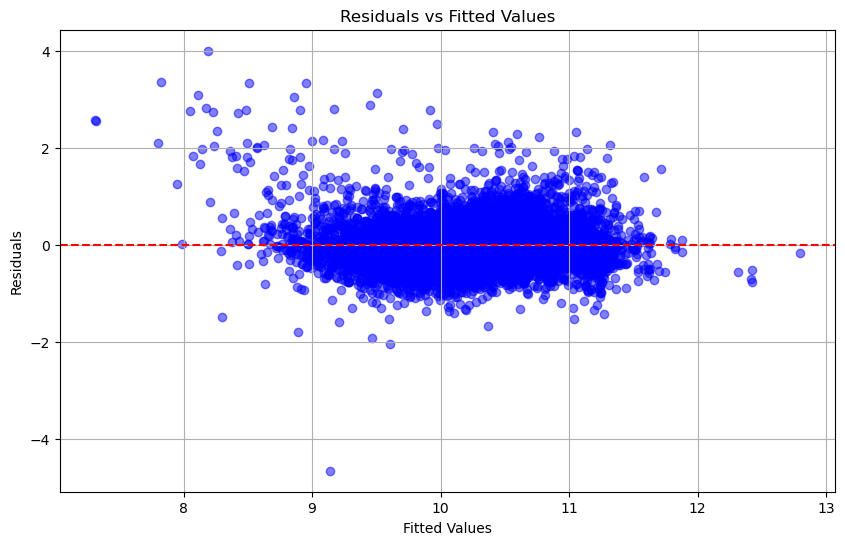

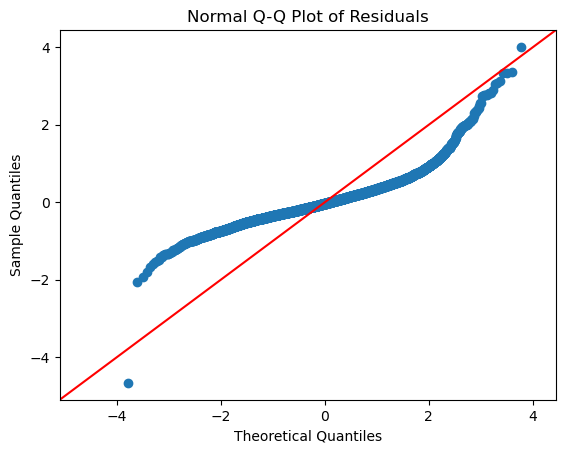

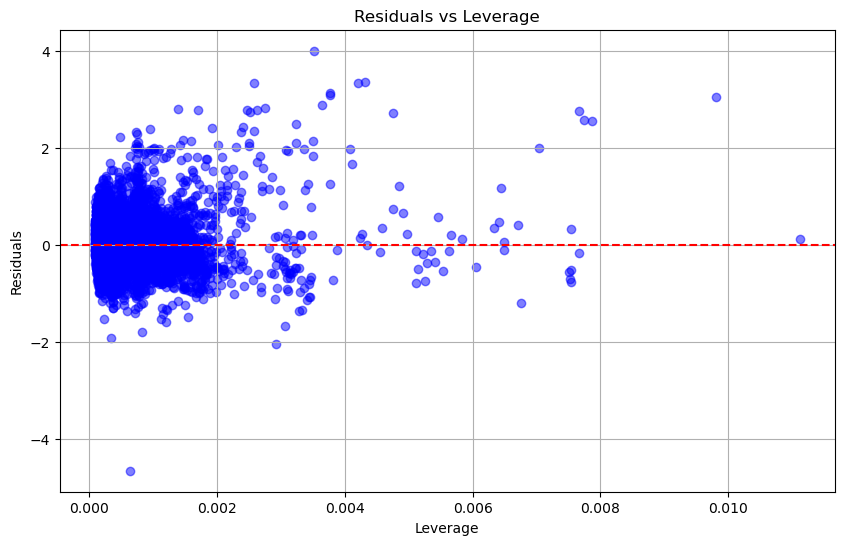

In [497]:
#13
# Инициализация начальных переменных (все переменные)
initial_features = X_train.columns.tolist()

# Выполняем пошаговый выбор переменных
selected_features = stepwise_selection(X_train, y_train, initial_features)

# Обучаем финальную модель с выбранными переменными
X_final = sm.add_constant(X_train[selected_features])
final_model = sm.OLS(y_train, X_final).fit()

# Предсказание значений на тестовой выборке
X_test_final = sm.add_constant(X_test[selected_features])

# Остатки
residuals = y_train - final_model.predict(X_final)

# График 1: Scatterplot
plt.figure(figsize=(10, 6))
plt.scatter(y_train, final_model.predict(X_final), color='blue', alpha=0.5)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], color='red', linestyle='--')  # Линия идеального предсказания
plt.title('Scatterplot of Actual vs Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.grid()
plt.show()

# График 2: Residuals vs Fitted
plt.figure(figsize=(10, 6))
plt.scatter(final_model.predict(X_final), residuals, color='blue', alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs Fitted Values')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.grid()
plt.show()

# График 3: Normal Q-Q
sm.qqplot(residuals, line='45')
plt.title('Normal Q-Q Plot of Residuals')
plt.show()

# График 4: Residuals vs Leverage
influence = final_model.get_influence()
leverage = influence.hat_matrix_diag
cooks_d = influence.cooks_distance[0]

plt.figure(figsize=(10, 6))
plt.scatter(leverage, residuals, color='blue', alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs Leverage')
plt.xlabel('Leverage')
plt.ylabel('Residuals')
plt.grid()
plt.show()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan, het_white
from sklearn.model_selection import train_test_split

# Предположим, что x и y уже определены как ваши данные.
# x - это DataFrame с независимыми переменными
# y - это Series или DataFrame с зависимой переменной

# Разделяем данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Обучаем модель
X_final = sm.add_constant(X_train)
model = sm.OLS(y_train, X_final).fit()

# Остатки
residuals = model.resid
fitted = model.fittedvalues

# Графический анализ: Residuals vs Fitted
plt.figure(figsize=(10, 6))
plt.scatter(fitted, residuals, color='blue', alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs Fitted Values')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.grid()
plt.show()

# Тест Бреуша-Пагана
bp_test = het_breuschpagan(residuals, X_final)
bp_results = pd.Series(bp_test, index=['LM Statistic', 'LM Test p-value', 'F Statistic', 'F Test p-value'])
print("Breusch-Pagan Test Results:\n", bp_results)

# Тест Уайта
white_test = het_white(residuals, X_final)
white_results = pd.Series(white_test, index=['LM Statistic', 'LM Test p-value', 'F Statistic', 'F Test p-value'])
print("\nWhite Test Results:\n", white_results)

In [477]:
#find best models
for model in models:
  print(model[0])
  PL=make_pipeline(model[1])

  cv=cross_validate(
    estimator=PL,
    X=x,
    y=y,
    cv=7, #train 6/7 test 1/7
    return_train_score=True,
    scoring=[
             'r2',
             'neg_mean_squared_error',#Negative Mean Squared Error, which is used to measure the average of the squares of the errors. 
             ]
    )
  print(model[0],'train r2 score = ',cv['train_r2∫'].mean())
  print(model[0],'test r2 score = ',cv['test_r2'].mean())
  print('-'*30)

lr


KeyError: 'train_r2∫'

In [ ]:
#best CatBoost, LGBM, XGB, Bagging

In [ ]:
best_models = [
    ('Bagging',BaggingRegressor()),
    ('XGB',XGBRegressor()),    
    ('LGBM', LGBMRegressor(verbose=-1)),
    ('CatBoost', CatBoostRegressor(silent=True))
]

In [ ]:
#show all metrics for best one
for model in best_models:
  print(model[0])
  PL=make_pipeline(transform,
                   MinMaxScaler(),

                   model[1])

  cv=cross_validate(
    estimator=PL,
    X=x,
    y=y,
    cv=5,
    return_train_score=True,
    scoring=[
             'r2',
             'neg_mean_squared_error',
             'neg_mean_absolute_error'
             ]
    )
  print(model[0],'train r2 score = ',cv['train_r2'].mean())
  print(model[0],'test r2 score = ',cv['test_r2'].mean())
  print(model[0],'train mean_squared_error = ',np.abs(cv['train_neg_mean_squared_error'].mean()))
  print(model[0],'test mean_squared_error = ',np.abs(cv['test_neg_mean_squared_error'].mean()))
  print(model[0],'train mean_absolute_error = ',np.abs(cv['train_neg_mean_absolute_error'].mean()))
  print(model[0],'test mean_absolute_error = ',np.abs(cv['test_neg_mean_absolute_error'].mean()))
  print('-'*30)

Bagging
Bagging train r2 score =  0.9578952241756958
Bagging test r2 score =  0.7659952197204541
Bagging train mean_squared_error =  0.01803245185241472
Bagging test mean_squared_error =  0.09927368536493458
Bagging train mean_absolute_error =  0.08470481807838856
Bagging test mean_absolute_error =  0.21474318109110718
------------------------------
XGB
XGB train r2 score =  0.8904048083532248
XGB test r2 score =  0.7974862352897357
XGB train mean_squared_error =  0.04691892180018546
XGB test mean_squared_error =  0.08616979410735824
XGB train mean_absolute_error =  0.15383185517467135
XGB test mean_absolute_error =  0.20303664193513643
------------------------------
LGBM
LGBM train r2 score =  0.8321326720541498
LGBM test r2 score =  0.7914300067818666
LGBM train mean_squared_error =  0.07188547595372383
LGBM test mean_squared_error =  0.0887230264720078
LGBM train mean_absolute_error =  0.1926914630988899
LGBM test mean_absolute_error =  0.21158598931936212
--------------------------

KeyboardInterrupt: 

In [ ]:
#find best parametrs
PL=make_pipeline(transform,
                  MinMaxScaler(),  # or StandardScaler()

                  XGBRegressor())

XGB_params=[
    {
        'xgbregressor__learning_rate':[0.05,0.1,0.15,0.20,0.25,0.30],
        'xgbregressor__max_depth':[3,4,5,6,8,10,12,15],
        'xgbregressor__min_child_weight':[1,3,5,7],
        'xgbregressor__gamma':[0.0,0.1,0.2,0.3,0.4],
        'xgbregressor__colsample_bytree':[0.3,0.4,0.5,0.7]

    }
]

XGBRegressor_RS = RandomizedSearchCV(PL, XGB_params,n_iter=80, scoring='r2', cv=5,n_jobs=-1)
XGBRegressor_RS.fit(x,y)

/opt/anaconda3/envs/math_stat/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/math_stat/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/math_stat/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/math_stat/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
          

XGBoostError: [08:45:22] /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/data/data.cc:514: Check failed: valid: Label contains NaN, infinity or a value too large.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x000000014906f1f0 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x00000001491d5adc xgboost::MetaInfo::SetInfoFromHost(xgboost::Context const&, xgboost::StringView, xgboost::Json) + 3644
  [bt] (2) 3   libxgboost.dylib                    0x00000001491d4acc xgboost::MetaInfo::SetInfo(xgboost::Context const&, xgboost::StringView, xgboost::StringView) + 472
  [bt] (3) 4   libxgboost.dylib                    0x0000000149086fb0 XGDMatrixSetInfoFromInterface + 240
  [bt] (4) 5   libffi.8.dylib                      0x000000010136404c ffi_call_SYSV + 76
  [bt] (5) 6   libffi.8.dylib                      0x0000000101361834 ffi_call_int + 1404
  [bt] (6) 7   _ctypes.cpython-311-darwin.so       0x000000010141c134 _ctypes_callproc + 752
  [bt] (7) 8   _ctypes.cpython-311-darwin.so       0x000000010141648c PyCFuncPtr_call + 228
  [bt] (8) 9   python3.11                          0x0000000100b31868 _PyEval_EvalFrameDefault + 193188



In [ ]:
print("Best value for lambda : ",XGBRegressor_RS.best_params_)
print("Best score for cost function: ", XGBRegressor_RS.best_score_)

In [ ]:
#metrics for best models
PL=make_pipeline(transform,
                  MinMaxScaler(),


                  XGBRegressor(min_child_weight= 1, max_depth= 8, learning_rate= 0.15, gamma= 0.0, colsample_bytree= 0.4))

cv=cross_validate(estimator=PL,
                  X=x,
                  y=y,
                  cv=5,
                  return_train_score=True,
                  scoring=[
                    'r2',
                    'neg_mean_squared_error',
                    'neg_mean_absolute_error'
                    ])
print('train r2 score = ',cv['train_r2'].mean())
print('test r2 score = ',cv['test_r2'].mean())
print('train mean_squared_error = ',np.abs(cv['train_neg_mean_squared_error'].mean()))
print('test mean_squared_error = ',np.abs(cv['test_neg_mean_squared_error'].mean()))  
print('train mean_absolute_error = ',np.abs(cv['train_neg_mean_absolute_error'].mean()))
print('test mean_absolute_error = ',np.abs(cv['test_neg_mean_absolute_error'].mean()))

train r2 score =  0.9804495127261331
test r2 score =  0.8939557467829025
train mean_squared_error =  0.008390083282345855
test mean_squared_error =  0.045429600926812266
train mean_absolute_error =  0.06851808328792922
test mean_absolute_error =  0.1383926059013226


In [ ]:
#find best parametrs
PL_BA=make_pipeline(transform,
                  MinMaxScaler(),

                  BaggingRegressor())

BA_params=[
    {
        'baggingregressor__bootstrap': [True,False],

'baggingregressor__max_features': [1.0,2.0,3.0],
'baggingregressor__max_samples': [1.0,1.5,2.0,3.0],
'baggingregressor__n_estimators': [10,50,100,200]

    }
]

Bagging_Regressor = RandomizedSearchCV(PL_BA, BA_params,n_iter=4, scoring='r2', cv=10,n_jobs=-1)
Bagging_Regressor.fit(x,y)

In [ ]:
print("Best value for lambda : ",Bagging_Regressor.best_params_)
print("Best score for cost function: ", Bagging_Regressor.best_score_)

In [ ]:
#metrics for best models
PL=make_pipeline(transform,
                MinMaxScaler(),  # or StandardScaler()

                BaggingRegressor(n_estimators= 200,max_samples= 1.0,max_features= 1.0,bootstrap= True))

cv=cross_validate(estimator=PL,
                  X=x,
                  y=y,
                  cv=5,
                  return_train_score=True,
                  scoring=[
                    'r2',
                    'neg_mean_squared_error',
                    'neg_mean_absolute_error'
                    ])
print('train r2 score = ',cv['train_r2'].mean())
print('test r2 score = ',cv['test_r2'].mean())
print('train mean_squared_error = ',np.abs(cv['train_neg_mean_squared_error'].mean()))
print('test mean_squared_error = ',np.abs(cv['test_neg_mean_squared_error'].mean()))  
print('train mean_absolute_error = ',np.abs(cv['train_neg_mean_absolute_error'].mean()))
print('test mean_absolute_error = ',np.abs(cv['test_neg_mean_absolute_error'].mean()))

train r2 score =  0.9827497450733013
test r2 score =  0.8697240834163431
train mean_squared_error =  0.00740010925221251
test mean_squared_error =  0.055744919096984924
train mean_absolute_error =  0.055423622438888376
test mean_absolute_error =  0.15400693725996212


In [ ]:
#find best parametrs
PL_CAT=make_pipeline(transform,
                  MinMaxScaler(),  # or StandardScaler()

                  CatBoostRegressor(silent=True))

CAT_params=[
    {
        'catboostregressor__learning_rate':[0.28,0.25,0.27,0.30,0.29,0.31,0.32],
        'catboostregressor__depth':[7,8,9],
        'catboostregressor__iterations':[400,500,600],
        'catboostregressor__l2_leaf_reg':[1,3,5,7,9]
    }
]

CAT_Regressor = RandomizedSearchCV(PL_CAT, CAT_params,n_iter=10, scoring='r2', cv=10,n_jobs=-1)
CAT_Regressor.fit(x,y)

In [ ]:
print("Best value for lambda : ",CAT_Regressor.best_params_)
print("Best score for cost function: ", CAT_Regressor.best_score_)

In [ ]:
#metrics for best models
PL=make_pipeline(transform,
                MinMaxScaler(),  # or StandardScaler()

                CatBoostRegressor(learning_rate= 0.27,depth= 8,iterations= 500,l2_leaf_reg = 5,silent= True))

cv=cross_validate(estimator=PL,
                  X=x,
                  y=y,
                  cv=5,
                  return_train_score=True,
                  scoring=[
                    'r2',
                    'neg_mean_squared_error',
                    'neg_mean_absolute_error'
                    ])
print('train r2 score = ',cv['train_r2'].mean())
print('test r2 score = ',cv['test_r2'].mean())
print('train mean_squared_error = ',np.abs(cv['train_neg_mean_squared_error'].mean()))
print('test mean_squared_error = ',np.abs(cv['test_neg_mean_squared_error'].mean()))  
print('train mean_absolute_error = ',np.abs(cv['train_neg_mean_absolute_error'].mean()))
print('test mean_absolute_error = ',np.abs(cv['test_neg_mean_absolute_error'].mean()))

train r2 score =  0.9895415834790546
test r2 score =  0.9053099032857818
train mean_squared_error =  0.0044862496417253424
test mean_squared_error =  0.04058508539001985
train mean_absolute_error =  0.05026205010090166
test mean_absolute_error =  0.13087571847169535


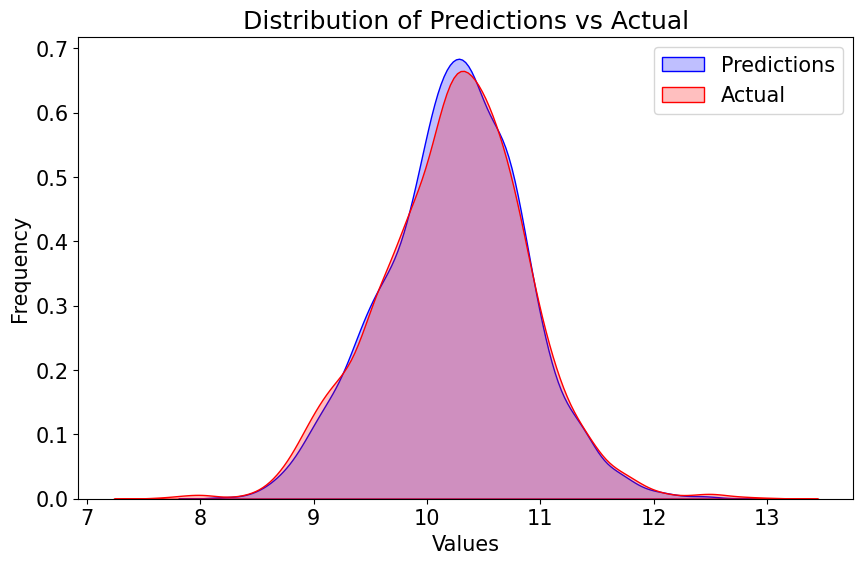

In [ ]:
# Assuming x and y are your features and target variable
X_train, X_valid, y_train, y_valid = train_test_split(x, y, test_size=0.2, random_state=42)

# Define the pipeline with the CatBoostRegressor
PL = make_pipeline(transform,
    MinMaxScaler(),
    CatBoostRegressor(learning_rate=0.27, depth=8, iterations=500, l2_leaf_reg=5, silent=True)
)

# Fit the model on the training set
PL.fit(X_train, y_train)

# Make predictions on the validation set
predictions = PL.predict(X_valid)

# Plot the distribution of predicted and actual values using Kernel Density Plot
plt.figure(figsize=(10, 6))
sns.kdeplot(predictions, color="blue", label="Predictions", fill=True)
sns.kdeplot(y_valid, color="red", label="Actual", fill=True)

# Set labels and legend
plt.xlabel("Values")
plt.ylabel("Frequency")
plt.title("Distribution of Predictions vs Actual")
plt.legend()

# Show the plot
plt.show()

In [ ]:
#clastering (used label encoder instead of onehot and binary)
features_cat = ['Brand', 'Model', 'UsedOrNew', 'Transmission', 'DriveType', 'FuelType', 'Color', 'BodyType', 'District', 'City']
data_c = data_copy.copy()
le = LabelEncoder()
for columna in feature_columnas:
    data_c[columna] = le.fit_transform(data_copy[columna])

In [ ]:
data_c.isna().sum()
data_c = data_c.astype(float)
data_c.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16140 entries, 0 to 16733
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Brand              16140 non-null  float64
 1   Model              16140 non-null  float64
 2   Year               16140 non-null  float64
 3   BodyType           16140 non-null  float64
 4   UsedOrNew          16140 non-null  float64
 5   Transmission       16140 non-null  float64
 6   EngineL            16140 non-null  float64
 7   DriveType          16140 non-null  float64
 8   FuelType           16140 non-null  float64
 9   FuelConsumption    16140 non-null  float64
 10  Kilometres         16140 non-null  float64
 11  Color              16140 non-null  float64
 12  CylindersinEngine  16140 non-null  float64
 13  Doors              16140 non-null  float64
 14  Seats              16140 non-null  float64
 15  State              16140 non-null  float64
 16  City               161

In [ ]:
dfs: list[pd.DataFrame] = []
for n in data_c:
    dfs.append(data_c)

cols = dfs[0].columns
clust_cols = [ "Kilometres","Price"]  # 2 основных канала

dfs[0]

,Brand,Model,Year,BodyType,UsedOrNew,Transmission,EngineL,DriveType,FuelType,FuelConsumption,Kilometres,Color,CylindersinEngine,Doors,Seats,State,City,Price
0,62.0,589.0,2022.0,6.0,0.0,0.0,2.2,1.0,0.0,8.7,8.629629,639.0,4.0,4.0,7.0,2.0,109.0,10.858807
1,41.0,469.0,2022.0,3.0,2.0,0.0,1.5,2.0,6.0,6.7,2.772589,38.0,4.0,5.0,5.0,2.0,77.0,9.902987
2,4.0,62.0,2022.0,2.0,2.0,0.0,2.0,4.0,6.0,6.6,9.044522,396.0,4.0,2.0,4.0,2.0,515.0,11.598993
3,46.0,265.0,2011.0,2.0,2.0,0.0,5.5,4.0,6.0,11.0,11.824204,683.0,8.0,2.0,4.0,2.0,365.0,10.403960
4,56.0,120.0,2022.0,6.0,2.0,0.0,1.3,2.0,7.0,6.0,6.942157,300.0,4.0,4.0,5.0,2.0,115.0,10.462818
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16729,67.0,115.0,2014.0,0.0,2.0,0.0,0.0,2.0,7.0,0.0,11.097410,275.0,0.0,7.0,0.0,4.0,451.0,10.292146
16730,46.0,596.0,2012.0,10.0,2.0,0.0,0.0,4.0,0.0,0.0,11.673615,485.0,0.0,0.0,0.0,7.0,436.0,10.593831
16731,64.0,701.0,2022.0,6.0,0.0,0.0,1.6,2.0,7.0,6.2,8.549660,785.0,4.0,4.0,5.0,4.0,165.0,10.471072
16732,46.0,339.0,2016.0,6.0,2.0,0.0,2.0,1.0,6.0,7.2,11.356564,300.0,4.0,4.0,5.0,4.0,4.0,10.642755


In [ ]:
def scatterplot2d(
    df: pd.DataFrame,
    col1: str = "Kilometres",
    col2: str = "Price",
    labels: Union[pd.Series, NDArray[np.int_]] = None,
    dots_size: int = 5,
    palette: str = "coolwarm",
) -> None:
    fig, _ = plt.subplots()
    sns.scatterplot(x=df[col1], y=df[col2], hue=labels, s=dots_size, palette=palette)
    fig.canvas.draw()

In [ ]:
%matplotlib inline
rcParams["font.size"] = 15
rcParams["figure.figsize"] = 16, 8

In [ ]:
def clust_and_viz(
    df: pd.DataFrame,
    clust_cols: list[str],
    clusterer: Any,
    dots_size: int = 5,
    palette: str = "coolwarm",
):
    clusterer.fit(df[clust_cols])
    labels = clusterer.labels_

    print(f"Число кластеров: {len(set(labels))}")

    scatterplot2d(
        df=df,
        col1=clust_cols[0],
        col2=clust_cols[1],
        labels=labels,
        dots_size=dots_size,
        palette=palette,
    )

    plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")

    return labels

In [ ]:
# Normalize
df = dfs[0].copy()
df_scaled = df.copy()

scaler = StandardScaler()
df_scaled[cols] = scaler.fit_transform(df_scaled[cols])

20

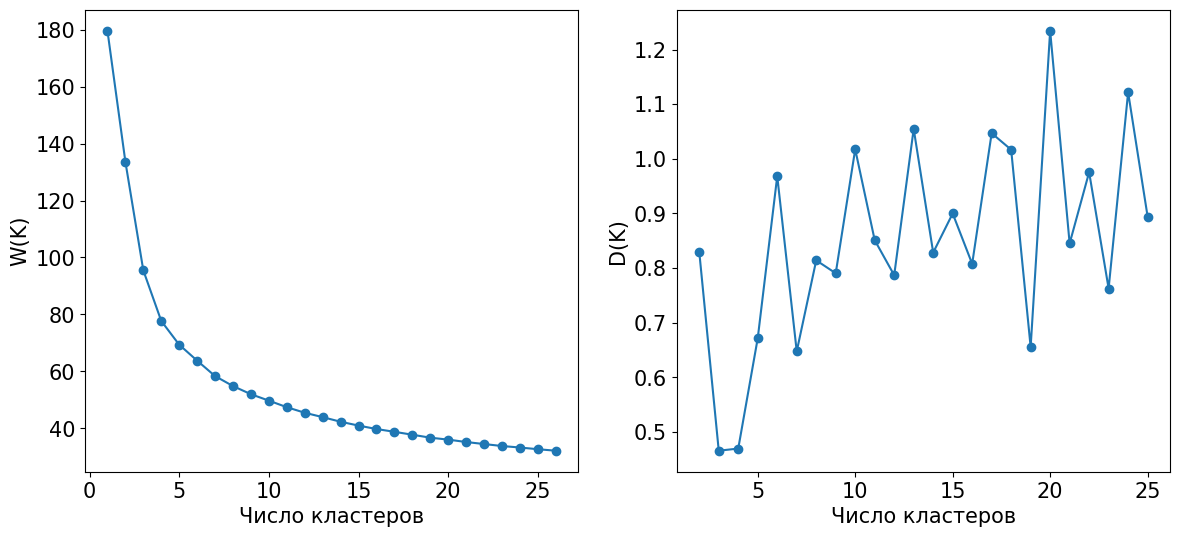

In [ ]:
def run_elbow_method(
    df: pd.DataFrame,
    clust_cols: list[str],
    max_k: int = 25,
    n_init: int = 10,
    seed: int = 42,
    plot_results: bool = True,
) -> int:
    w_k = []
    for k in range(1, max_k + 2):
        kmeans = KMeans(n_clusters=k, n_init=n_init, random_state=seed).fit(
            df[clust_cols]
        )
        w_k.append(np.sqrt(kmeans.inertia_))

    # Analythical method to pick the optimal number of clasters
    d_k = []
    for idx in range(1, max_k):
        d_k.append(abs(w_k[idx] - w_k[idx + 1]) / abs(w_k[idx - 1] - w_k[idx]))

    if plot_results:
        fig, axs = plt.subplots(1, 2, figsize=(14, 6))
        axs[0].plot(range(1, max_k + 2), w_k, marker="o")
        axs[0].set_xlabel("Число кластеров")
        axs[0].set_ylabel("W(K)")
        axs[1].plot(range(2, max_k + 1), d_k, marker="o")
        axs[1].set_xlabel("Число кластеров")
        axs[1].set_ylabel("D(K)")

    return np.argmax(d_k) + 2


run_elbow_method(df=df_scaled, clust_cols=clust_cols)

In [ ]:
def plot_sorted_nn_dists(df: pd.DataFrame, min_pts: int = 4) -> None:
    neighbors_fit = NearestNeighbors(n_neighbors=min_pts).fit(df)
    distances, indices = neighbors_fit.kneighbors(df)
    distances = np.sort(distances, axis=0)
    distances = distances[:, 1]

    plt.figure()
    plt.plot(distances)

In [ ]:
clustering = {
    "dbscan": {
        "method": DBSCAN,
        "params_range": {
            "eps": [*np.arange(0.1, 0.01, -0.01)],
            "min_samples": [*range(25, 0, -1)],
            "metric": ["euclidean", "manhattan"],
            "n_jobs": [*range(1, 5), -1],
        },
    },
    "kmeans": {
        "method": KMeans,
        "params_range": {
            "n_clusters": [*range(2, 31)],
            "n_init": [*range(3, 26)],
            "random_state": 42,
        },
    },
    "mbkmeans": {
        "method": MiniBatchKMeans,
        "params_range": {
            "n_clusters": [*range(2, 31)],
            "batch_size": [*range(100, 1001, 100)],
            "n_init": [*range(3, 26)],
            "random_state": 42,
        },
    },
    "agglomerative": {
        "method": AgglomerativeClustering,
        "params_range": {
            "n_clusters": [*range(2, 31)],
            "linkage": ["ward", "complete", "average", "single"],
        },
    },
    "birch": {
        "method": Birch,
        "params_range": {
            "threshold": [*np.arange(0.1, 1.1, 0.1)],
            "branching_factor": [*range(20, 101, 10)],
            "n_clusters": [*range(2, 31)],
        },
    },
}

In [ ]:
class InteractiveClusterer:
    def __init__(
        self,
        method: Any,
        params_range: dict[str, Any],
        dfs: list[pd.DataFrame],
        scaler: TransformerMixin = StandardScaler(),
    ) -> None:
        self.method = method
        self.clusterer: Any = None
        self.params_range = params_range
        self.dfs = dfs
        self.curr_df = None

    @lru_cache(maxsize=None)
    def fit_predict(
        self,
        patient: int = 0,
        col1: str = "Kilometres",
        col2: str = "Price",
        do_scaling: bool = False,
        **kwargs,
    ) -> NDArray[np.int_]:
        self.clusterer = self.method(**kwargs)
        self.clusterer.fit(self.curr_df)
        return self.clusterer.labels_

    def analysis2d(
        self,
        print_clust_num: bool = False,
        dots_size: int = 5,
        palette: str = "coolwarm",
        patient: int = 0,
        col1: str = "Kilometres",
        col2: str = "Price",
        do_scaling: bool = True,
        plot_scaled: bool = True,
        **kwargs,
    ) -> None:
        self.curr_df = self.dfs[patient][[col1, col2]].copy()

        if do_scaling:
            self.curr_df[self.curr_df.columns] = scaler.fit_transform(self.curr_df)

        labels = self.fit_predict(
            patient=patient, col1=col1, col2=col2, do_scaling=do_scaling, **kwargs
        )

        if print_clust_num:
            print("Число кластеров:", len(set(labels)))

        scatterplot2d(
            df=self.curr_df if plot_scaled else self.dfs[patient],
            col1=col1,
            col2=col2,
            labels=labels,
            dots_size=dots_size,
            palette=palette,
        )



In [ ]:
def create_clusterer(method_name, print_clust_num, dots_size, palette, patient, col1, col2, do_scaling, plot_scaled, **params):
    scaler = MinMaxScaler()  # or StandardScaler()
    clusterer = InteractiveClusterer(**clustering[method_name], dfs=dfs, scaler=scaler)
    clusterer.analysis2d(
        print_clust_num=print_clust_num,
        dots_size=dots_size,
        palette=palette,
        patient=patient,
        col1=col1,
        col2=col2,
        do_scaling=do_scaling,
        plot_scaled=plot_scaled,
        **params
    )

In [ ]:
def update_interact(method_name):
    params = clustering[method_name]['params_range']
    interact(create_clusterer,
             method_name=widgets.fixed(method_name),
             print_clust_num=widgets.Checkbox(value=True, description='Print Cluster Number'),
             dots_size=widgets.IntSlider(min=1, max=25, step=1, value=5, description='Dots Size'),
             palette=widgets.Dropdown(options=["coolwarm", "bright"], value="coolwarm", description="Palette"),
             patient=widgets.IntSlider(min=0, max=9, step=1, value=0, description='Patient'),
             col1=widgets.Dropdown(options=cols, value=cols[0], description="Col1"),
             col2=widgets.Dropdown(options=cols, value=cols[1], description="Col2"),
             do_scaling=widgets.Checkbox(value=False, description='Do Scaling'),
             plot_scaled=widgets.Checkbox(value=False, description='Plot Scaled'),
             **{key: widgets.Select(options=value) if isinstance(value, list) else widgets.fixed(value)
                for key, value in params.items()})

In [ ]:
warnings.filterwarnings("ignore", message=".*MiniBatchKMeans is known to have a memory leak.*")

# Dropdown for method selection
method_dropdown = widgets.Dropdown(
    options=['dbscan', 'kmeans', 'mbkmeans',"agglomerative","birch"],
    value='dbscan',
    description='Method:',
)

# Link the dropdown to the update function
widgets.interactive(update_interact, method_name=method_dropdown)

interactive(children=(Dropdown(description='Method:', options=('dbscan', 'kmeans', 'mbkmeans', 'agglomerative'…